In [ ]:
import os
import zipfile
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Configuración de rutas
ruta_zip = '/content/drive/MyDrive/ia/GeolifeTrajectories1.3.zip'
directorio_destino = '/content/Geolife'

# Crear directorio si no existe
os.makedirs(directorio_destino, exist_ok=True)

# Descomprimir con manejo de errores
try:
    with zipfile.ZipFile(ruta_zip, 'r') as zip_ref:
        zip_ref.extractall(directorio_destino)
    print("¡Descompresión exitosa!")
except Exception as e:
    print(f"Error al descomprimir: {str(e)}")

¡Descompresión exitosa!


In [ ]:
# Cargar datos
import pandas as pd
import numpy as np

def cargar_y_procesar(ruta_plt):
    # Cargar datos (saltar 6 filas de metadatos)
    df = pd.read_csv(ruta_plt, skiprows=6, header=None,
                     names=['lat', 'lon', 'cero', 'alt', 'dias', 'fecha', 'hora'])

    df['tiempo'] = pd.to_datetime(df['fecha'] + ' ' + df['hora'])
    df['delta_t'] = df['tiempo'].diff().dt.total_seconds()
    df['delta_km'] = np.sqrt(df['lat'].diff()**2 + df['lon'].diff()**2) * 111.32  # 1 grado ≈ 111.32 km
    df['velocidad_kmh'] = (df['delta_km'] / (df['delta_t'] / 3600)).fillna(0)

    df['target'] = (df['velocidad_kmh'] > 20).astype(int)

    return df

# Ejemplo con un archivo
ruta_ejemplo = '/content/Geolife/Geolife Trajectories 1.3/Data/000/Trajectory/20081023025304.plt'
df = cargar_y_procesar(ruta_ejemplo)
print(df[['lat', 'lon', 'velocidad_kmh', 'target']].head())




         lat         lon  velocidad_kmh  target
0  39.984702  116.318417       0.000000       0
1  39.984683  116.318450       2.543364       0
2  39.984686  116.318417       2.655870       0
3  39.984688  116.318385       2.569817       0
4  39.984655  116.318263      10.129755       0


In [ ]:
X = df[['velocidad_kmh']].values
y = df['target'].values

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 128)  # Capa oculta 1
        self.fc2 = nn.Linear(128, 64)                 # Capa oculta 2
        self.fc3 = nn.Linear(64, len(np.unique(y)))   # Capa de salida

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = NeuralNet()
print(model)

NeuralNet(
  (fc1): Linear(in_features=1, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Convertir los datos a tensores
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# Entrenamiento
num_epochs = 20
loss_values = []
accuracy_values = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    # Calcular precisión durante el entrenamiento
    _, predicted = torch.max(outputs.data, 1)
    total = y_train_tensor.size(0)
    correct = (predicted == y_train_tensor).sum().item()
    accuracy = 100 * correct / total

    loss_values.append(loss.item())
    accuracy_values.append(accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%')

Epoch [1/20], Loss: 0.7347, Accuracy: 2.75%
Epoch [2/20], Loss: 0.6784, Accuracy: 96.83%
Epoch [3/20], Loss: 0.6256, Accuracy: 96.69%
Epoch [4/20], Loss: 0.5790, Accuracy: 96.56%
Epoch [5/20], Loss: 0.5388, Accuracy: 96.42%
Epoch [6/20], Loss: 0.5022, Accuracy: 96.42%
Epoch [7/20], Loss: 0.4685, Accuracy: 96.42%
Epoch [8/20], Loss: 0.4367, Accuracy: 96.42%
Epoch [9/20], Loss: 0.4064, Accuracy: 96.42%
Epoch [10/20], Loss: 0.3777, Accuracy: 96.56%
Epoch [11/20], Loss: 0.3511, Accuracy: 96.56%
Epoch [12/20], Loss: 0.3263, Accuracy: 96.56%
Epoch [13/20], Loss: 0.3038, Accuracy: 96.56%
Epoch [14/20], Loss: 0.2831, Accuracy: 96.69%
Epoch [15/20], Loss: 0.2642, Accuracy: 96.69%
Epoch [16/20], Loss: 0.2466, Accuracy: 96.69%
Epoch [17/20], Loss: 0.2305, Accuracy: 96.69%
Epoch [18/20], Loss: 0.2158, Accuracy: 96.69%
Epoch [19/20], Loss: 0.2024, Accuracy: 96.69%
Epoch [20/20], Loss: 0.1902, Accuracy: 96.83%


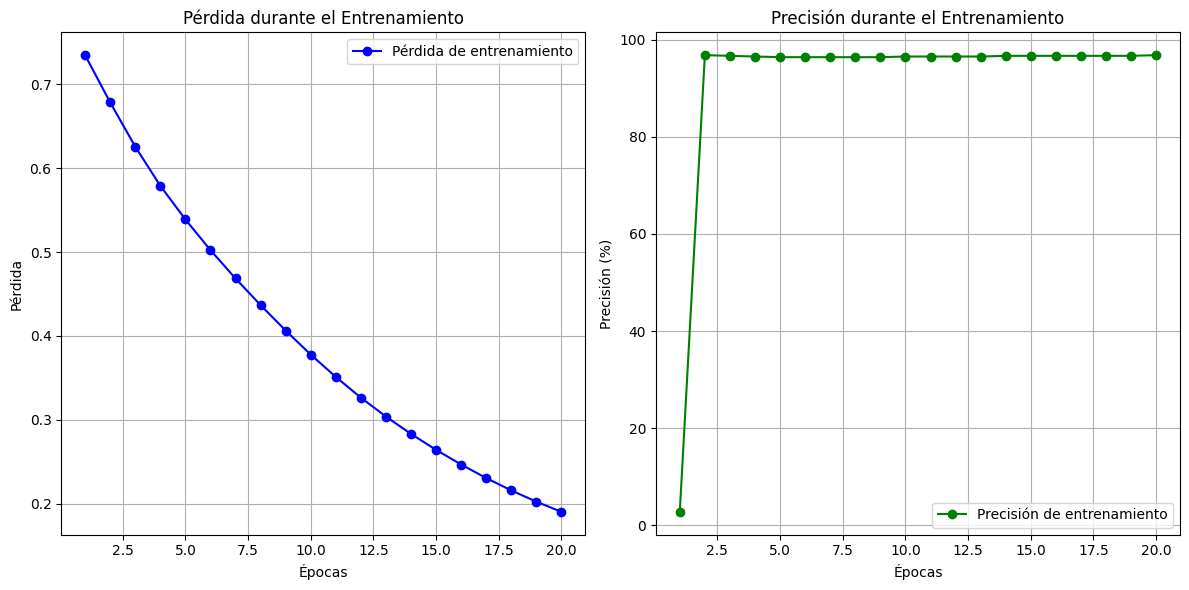

In [ ]:
# Graficar la pérdida durante el entrenamiento
plt.figure(figsize=(12, 6))

# Subgráfico para la pérdida
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), loss_values, marker='o', color='b', label='Pérdida de entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Pérdida durante el Entrenamiento')
plt.legend()
plt.grid(True)

# Subgráfico para la precisión
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), accuracy_values, marker='o', color='g', label='Precisión de entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión (%)')
plt.title('Precisión durante el Entrenamiento')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
model.eval()  # modo de evaluación
correct = 0
total = 0
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    total = y_test_tensor.size(0)
    correct = (predicted == y_test_tensor).sum().item()

accuracy = 100 * correct / total
print(f'Precisión final del modelo en el conjunto de prueba: {accuracy:.2f}%')

Precisión final del modelo en el conjunto de prueba: 98.35%
